## Imports

In [11]:
import matplotlib.pyplot as plt

import numpy as np
import torch

torch.cuda.empty_cache()

from src.models.TurbulenceNetwork import TurbulenceNetworkBayesian
from src.data_gens.TurbulenceClosureDataGenerator import TurbulenceClosureDataGenerator
from src.utils.plot_utils import plot_data_generation_diff, plot_heat_map_compare, plot_heat_map_loss, plot_heat_map_3D
from src.utils.model_utils import *
from src.utils.data_utils import *

from src.models.GaussianProcess import GaussianProcessRegressor, RBFKernel

#DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE = 'cpu'

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Creating Data

/home/codygrogan/PythonProjects/Uncertainty_Quantification/src/data_gens/TurbulenceClosureDataGenerator.py:88: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos((-b/2)/np.sqrt(-a**3/27))


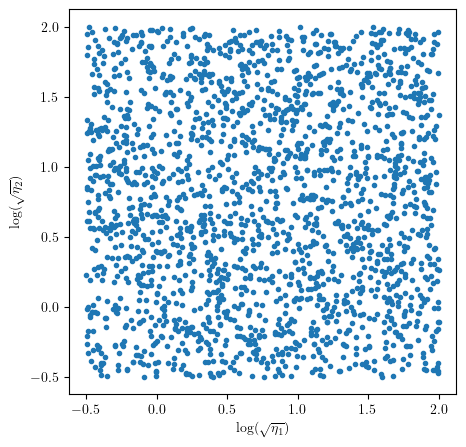

In [10]:
# Data generators for the different turbulence closures
SSG_gen = TurbulenceClosureDataGenerator('SSG')

# Defining the ranges for the different scales
log = (-.5, 2.0)

# Defining whether to exclude certain areas of the data
exclude_area = False
include_area = False
drop_eta_1 = False
drop_eta_2 = False
add_noise = False

# Defining area to exclude datapoints
eta_1_range = (10**np.array([-.1, 0.0]))**2
eta_2_range = (10**np.array([-.3, 0.0]))**2

etas_train, gs_train = generate_log_data(SSG_gen, log, 2000, shuffle=True, gen_type="all")

etas_test, gs_test = generate_log_data(SSG_gen, log, 600, shuffle=True, gen_type="All")

if not drop_eta_1 and not drop_eta_2:
    plot_data_generation_diff(etas_train)

## Defining Data Sets and Scaling

In [9]:
from sklearn.preprocessing import StandardScaler

x_scaler = CustomScalerX().fit(etas_train)
y_scaler = StandardScaler().fit(gs_train)

x_train = torch.tensor(x_scaler.transform(etas_train), device=DEVICE)
y_train = torch.tensor(y_scaler.transform(gs_train), device=DEVICE)

x_test = torch.tensor(x_scaler.transform(etas_test), device=DEVICE)
y_test = torch.tensor(y_scaler.transform(gs_test), device=DEVICE)

## Training

In [12]:
trained_gps = []

for i in range(y_train.shape[1]):
    kernel = RBFKernel(length_scale=1.0, amplitude=1.0, device=DEVICE).to(DEVICE)
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts=1, batch_size=200, device=DEVICE)

    gp = gp.fit(x_train, y_train[:, i].unsqueeze(1))
    trained_gps.append(gp)

for gp in trained_gps:
    print(gp.kernel.length_scale, gp.kernel.amplitude)


#kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-6, 1e2))
#gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5)
#gp = gp.fit(x_train, y_train)

Iteration 0, Loss: -6.8316851748663225
Iteration 100, Loss: -81.08653066016308
Iteration 200, Loss: -76.0902757628644
Iteration 300, Loss: -78.26506989814692
Iteration 400, Loss: -87.95946961035224
Iteration 500, Loss: -85.3340714467929
Iteration 600, Loss: -89.19221560414695
Iteration 700, Loss: -87.46646238979707
Iteration 800, Loss: -94.48113831972114
Iteration 900, Loss: -79.98630103503814
Iteration 0, Loss: -87.59421108446463
Iteration 100, Loss: -80.9415919306876
Iteration 200, Loss: -100.07592062179828
Iteration 300, Loss: -93.8562941527399
Iteration 400, Loss: -78.17466599902184
Iteration 500, Loss: -82.137944671595
Iteration 600, Loss: -100.64878326014423
Iteration 700, Loss: -79.86180858375917
Iteration 800, Loss: -84.77717901031576
Iteration 900, Loss: -83.74261315082276
Iteration 0, Loss: -8.358850488170134
Iteration 100, Loss: -53.89699384266396
Iteration 200, Loss: -21.284651311867947
Iteration 300, Loss: -41.98409209014898
Iteration 400, Loss: -59.59907127073063
Iteratio

AttributeError: 'GaussianProcessRegressor' object has no attribute 'log_marginal_likelihood'

## Plotting Samples

In [29]:
dim = 700
x_grid, y_grid = np.meshgrid(np.linspace(*log, dim),np.linspace(*log, dim))
eta1 = (10**x_grid.flatten())**2
eta2 = (10**y_grid.flatten())**2

gen = TurbulenceClosureDataGenerator(model="SSG", type='torch')
etas, G_s = gen(eta1, eta2)
target = G_s

etas = x_scaler.transform(etas)
etas = torch.tensor(etas, device=DEVICE)

pred_mean = []
pred_std = []

num_splits = 60

for x_split in np.array_split(etas, num_splits):
    pred_mean_split = np.zeros((x_split.shape[0], len(trained_gps)))
    pred_std_split = np.zeros((x_split.shape[0], len(trained_gps)))

    for i, gp in enumerate(trained_gps):
        pred, std = gp.predict(x_split, return_std=True)
        pred_mean_split[:, i], pred_std_split[:, i] = (pred.cpu().detach().numpy(), std.cpu().detach().numpy())
    
    pred_mean.append(pred_mean_split)
    pred_std.append(pred_std_split)

pred_mean = np.concatenate(pred_mean, axis=0)
pred_std = np.concatenate(pred_std, axis=0)


# y = ln(-G_1)
# E[G_1] = E[-e^y] -e^E[y]

#pred_mean, pred_std = gp.predict(etas, return_std=True)

pred_mean = y_scaler.inverse_transform(pred_mean)
pred_std = pred_std * y_scaler.scale_

print(np.mean(np.abs(target - pred_mean)))

plot_heat_map_compare(x_grid, y_grid, target.T.reshape(3, dim, dim), pred_mean.T.reshape(3, dim, dim))

plot_heat_map_3D(x_grid, y_grid, pred_std.T.reshape(3, dim, dim))

OutOfMemoryError: CUDA out of memory. Tried to allocate 510.00 MiB. GPU 0 has a total capacity of 5.70 GiB of which 470.44 MiB is free. Process 23008 has 196.00 MiB memory in use. Including non-PyTorch memory, this process has 5.03 GiB memory in use. Of the allocated memory 4.66 GiB is allocated by PyTorch, and 203.37 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## Output CHPC Result

### Getting test outputs for each sample

8.841085269176235e-08


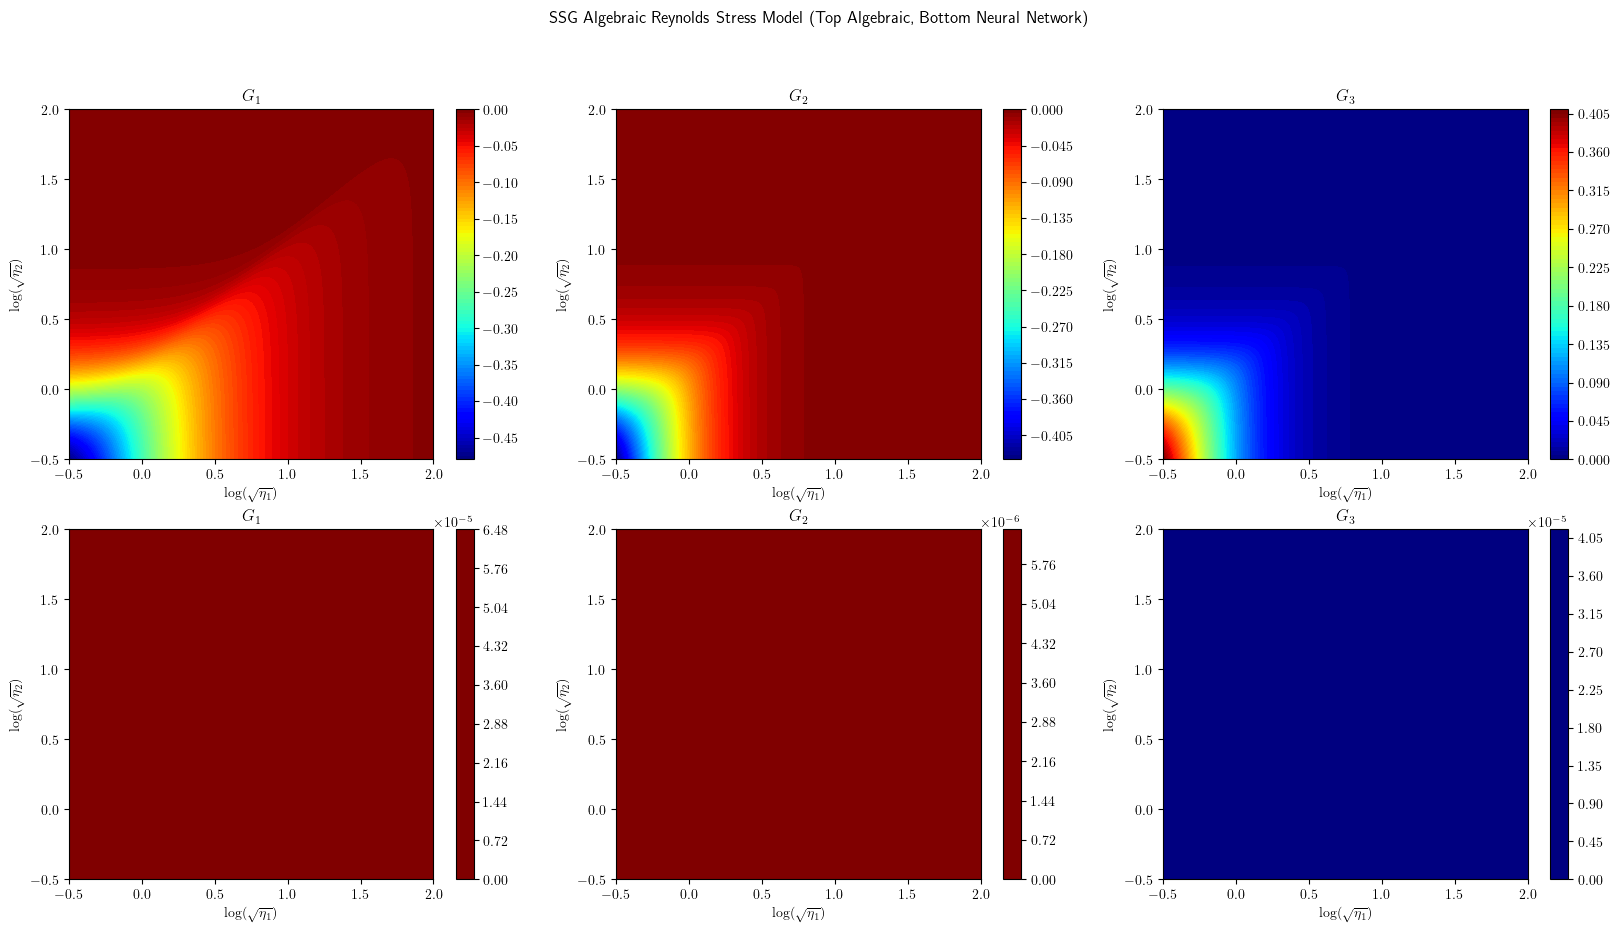

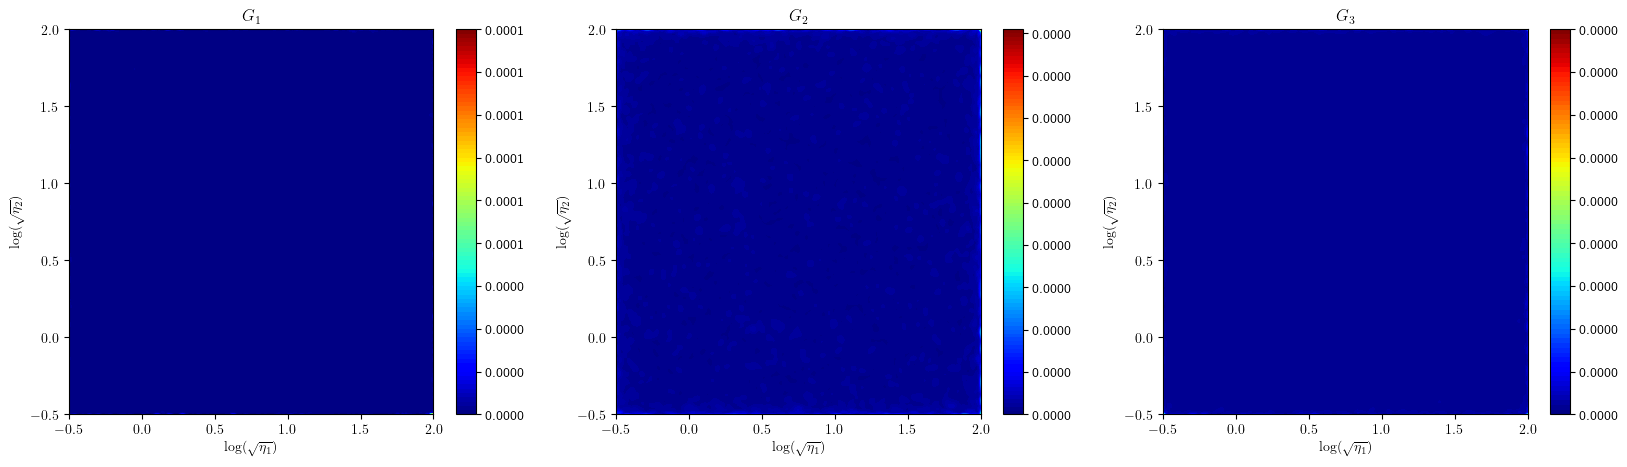

In [5]:
data_dir = "data/GP/GP_chpc/"

preds = []
stds = []

for i in range(3):
    pred = np.load(data_dir + f"Mean{i}.npy")
    std = np.load(data_dir + f"Std{i}.npy").reshape(-1, 1)
    preds.append(pred)
    stds.append(std)

preds = np.concatenate(preds, axis=1)
stds = np.concatenate(stds, axis=1)

dim = 700
x_grid, y_grid = np.meshgrid(np.linspace(*log, dim),np.linspace(*log, dim))
eta1 = (10**x_grid.flatten())**2
eta2 = (10**y_grid.flatten())**2

gen = TurbulenceClosureDataGenerator(model="SSG", type='torch')
etas, G_s = gen(eta1, eta2)

print(np.mean(np.abs(G_s - preds)))

plot_heat_map_compare(x_grid, y_grid, G_s.T.reshape(3, dim, dim), np.abs(preds.T.reshape(3, dim, dim) - G_s.T.reshape(3, dim, dim)))

plot_heat_map_3D(x_grid, y_grid, stds.T.reshape(3, dim, dim))